<a href="https://www.kaggle.com/code/georgiosspyrou1/youtube-video-virality-predictor-eda?scriptVersionId=240465593" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚀 YouTube Trending Video Analytics and Virality Estimation 

![Python](https://img.shields.io/badge/-Python-000?&logo=Python)
![YouTube API](https://img.shields.io/badge/-YouTube_API-FF0000?&logo=youtube&logoColor=white)
![GitHub Actions](https://img.shields.io/badge/-GitHub_Actions-2088FF?&logo=github-actions&logoColor=white)

## 🎯 YouTube Trending Video Analytics

### **Project Purpose**  
The **Tube Virality** project aims to **collect, analyze, and model YouTube trending video data** across multiple countries using the **YouTube API**. It aims to gather metrics like view counts, likes, and descriptions, then apply data science techniques to predict a video's likelihood of going viral.


### **Key Objectives**  
- ✅ **Collect Data via YouTube API**: Fetch trending videos and their statistics
- ✅ **Build Historical Database**: Track daily metrics for trending videos across countries
- ✅ **Identify Virality Patterns**: Analyze what characteristics correlate with viral success
- ✅ **Develop Predictive Models**: Create ML models to estimate virality potential
- ✅ **Provide Actionable Insights**: Help content creators understand virality factors

---

## 🛠️ How the Data is Collected  

The data is automatically collected using the **YouTube API** and stored in this GitHub location:  
🔗 [Trending Video Metadata](https://github.com/gpsyrou/tube-virality/tree/main/assets/meta/trending)  

### **Data Collection Process**  
1. **Fetching Trending Videos**  
   - Using the YouTube API, trending videos from multiple countries are retrieved.  
   - The list of trending videos is stored and continuously updated (_daily updates_).

2. **Daily Statistics Updates** (Automated via **GitHub Actions**)  
   - A scheduled **GitHub Actions** workflow updates video statistics (views, likes, comments, video descrition, video privacy status, etc.).  
   - These updates provide **historical trends** for analysis.  
   - The latest data is stored here:  
     🔗 [Video Statistics](https://github.com/gpsyrou/tube-virality/tree/main/assets/meta/video_stats)  

```mermaid
graph TD;
    A[trending.py: Fetch Trending Videos] -->|Generates daily JSON files - one per country| B[trending_db.py: Aggregate Trending Data];
    B -->|Merges all country JSONs into a unified CSV| C[video_stats.py: Extract & Fetch Video Stats];
    C -->|Creates a daily JSON file with statistics for all videos| D[video_stats_db.py: Compile Video Stats History];
    D -->|Combines all daily stats JSONs into a final dataset| E[Complete Merged Video Stats JSON];
```
---

## 📈 Defining Video Virality  

Virality isn't simply measured by raw view count. Our analysis considers multiple factors, for example:
- A YouTuber with **1M subscribers** getting **20M views** is - potentially- expected.  
- A YouTuber with **10K subscribers** getting **2M views** is **extraordinary**.  

Our models will classify videos as **"success" (viral)** or **"non-success"**, based on the metrics retrieved, but the success/non-success will be up to us to decide.



### 🔎 **Key Virality Metrics**  

| **Metric**            | **Description**                                             | **Importance** |
|------------------------|------------------------------------------------------------|----------------|
| **Engagement Rate**     | Likes, comments, and shares relative to views             | High           |
| **Growth Velocity**     | How quickly a video gains views in the first hours/days   | Critical       |
| **Audience Reach**      | Views relative to channel subscriber count                | High           |
| **Subscriber Growth**   | New subscribers gained after video publication            | Medium         |
| **Trending Duration**   | How long a video remains on trending lists                | Medium         |

---

## 📊 Dataset & Features  

Our dataset includes key **video metadata** and **engagement statistics**, such as:  

- **Video Details**: Title, description, duration, resolution  
- **Engagement Metrics**: Views, likes, comments, favorite count  
- **Channel Details**: Subscriber count, total videos, upload frequency  
- **Trending History**: How long a video remains on the trending list  
- **Country-Based Analysis**: Virality trends across different regions  

📌 **Goal:** Use these features to identify patterns and train models for virality prediction.  

---

## 🔬 Methodology  

1️⃣ **Data Collection** – Retrieve daily trending videos across countries.  
2️⃣ **Data Cleaning & Preprocessing** – Handle missing values, outliers, and standardize data.  
3️⃣ **Exploratory Analysis** – Identify key trends and patterns.  
4️⃣ **Feature Engineering** – Extract additional insights like growth rate and engagement score.  
5️⃣ **Model Development** – Train ML models for virality prediction.  
6️⃣ **Evaluation & Interpretation** – Validate predictions and refine models.  

---

## 🔨  Technologies Utilized  

We've harnessed a blend of cutting-edge technologies to power the **Tube Virality** project:  
🔹 **Python 3.9** – Data processing, analysis, and ML model training. (currently)<br/>
🔹 **SQL** – Storing structured video metadata for analysis. (future iteration)


<br/>

# Analysis

In [1]:
import re
import json
import logging
import requests
import warnings
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import Optional, Union, List, Dict, Any, Tuple

In [2]:
class GitHubDataLoader:
    def __init__(self, user: str, repo: str, file_path: str, branch: str = "main") -> None:
        self.user = user
        self.repo = repo
        self.file_path = file_path
        self.branch = branch
        self.raw_url = f"https://raw.githubusercontent.com/{self.user}/{self.repo}/{self.branch}/{self.file_path}"

    def get_csv_file(self) -> str:
        response: requests.Response = requests.get(self.raw_url)
        response.raise_for_status()
        return response.text

    def csv_to_dataframe(self, csv_content: str) -> pd.DataFrame:
        df = pd.read_csv(StringIO(csv_content))
        return df

In [3]:
YOUTUBE_CATEGORY_MAP = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy (Movies)",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

## Trending Videos Analysis

In [4]:
loader = GitHubDataLoader(user='gpsyrou', repo='tube-virality', branch='main', file_path='db/ods/trending_videos.csv')

trending_videos_content = loader.get_csv_file()

trending_videos_df = loader.csv_to_dataframe(trending_videos_content)

In [5]:
print(trending_videos_df.shape)

(99087, 15)


In [6]:
trending_videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99087 entries, 0 to 99086
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    99087 non-null  object 
 1   trending_position     99087 non-null  int64  
 2   collection_date       99087 non-null  object 
 3   publishedAt           99087 non-null  object 
 4   country_code          99087 non-null  object 
 5   channelId             99087 non-null  object 
 6   channelTitle          99087 non-null  object 
 7   title                 99087 non-null  object 
 8   description           82917 non-null  object 
 9   categoryId            99087 non-null  int64  
 10  viewCount             99040 non-null  float64
 11  likeCount             97435 non-null  float64
 12  commentCount          98362 non-null  float64
 13  thumbnail_url         99087 non-null  object 
 14  defaultAudioLanguage  74966 non-null  object 
dtypes: float64(3), int6

In [7]:
trending_videos_df.describe()

,trending_position,categoryId,viewCount,likeCount,commentCount
count,99087.000000,99087.000000,9.904000e+04,9.743500e+04,98362.000000
mean,25.496856,19.617922,1.033701e+07,2.815884e+05,4373.402747
std,14.429275,6.314977,2.381010e+07,6.848453e+05,19702.233935
min,1.000000,1.000000,1.117700e+04,2.100000e+01,0.000000
25%,13.000000,17.000000,3.835630e+05,1.199700e+04,362.000000
50%,25.000000,22.000000,1.155456e+06,3.939600e+04,1135.000000
75%,38.000000,24.000000,7.489246e+06,2.081855e+05,3156.750000
max,50.000000,29.000000,3.222258e+08,1.016152e+07,550226.000000


In [8]:
trending_videos_df.describe(include=["object", "bool"])

,id,collection_date,publishedAt,country_code,channelId,channelTitle,title,description,thumbnail_url,defaultAudioLanguage
count,99087,99087,99087,99087,99087,99087,99087,82917,99087,74966
unique,18771,79,18208,30,8444,8471,18977,15829,18773,77
top,TTVbph1KLG8,2025-04-07,2025-03-24T15:41:02Z,GR,UCX6OQ3DkcsbYNE6H8uQQuVA,MrBeast,"Cool Items!🥰 New Gadgets, Smart Appliances, Ki...",Subscribe ❤️,https://i.ytimg.com/vi/TTVbph1KLG8/hqdefault.jpg,en
freq,227,1500,227,3950,561,561,313,475,227,21757


In [9]:
class ODSToStageProcessor:
    """
    Processes and cleans YouTube data from ODS (raw) format to a cleaner stage format.
    """
    def __init__(self, category_map: dict = {}):
        self.category_map = category_map
        
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def pt_to_minutes(self, pt_string: str):
        """Convert ISO 8601 duration format (PT format) to minutes"""
        if not isinstance(pt_string, str) or not pt_string.startswith("PT"):
            return 0.0
        
        match = re.match(r"^PT(\d+H)?(\d+M)?(\d+S)?$", pt_string)
        if match:
            hours = int(match.group(1).replace('H', '') if match.group(1) else 0)
            minutes = int(match.group(2).replace('M', '') if match.group(2) else 0)
            seconds = int(match.group(3).replace('S', '') if match.group(3) else 0)
            return hours * 60 + minutes + (seconds / 60)
        return 0.0

    def trending_ods_to_stage(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Cleans and preprocesses a YouTube trending videos DataFrame for analysis.
        """
        self.logger.info("Started processing trending ODS data.")
        df = df.copy()
        
        try:
            df.rename(columns={'id': 'video_id'}, inplace=True)
            self.logger.info("Renamed columns successfully.")
        except Exception as e:
            self.logger.error(f"Error renaming columns: {e}")

        try:
            df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce").dt.strftime('%Y-%m-%d %H:%M:%S')
            self.logger.info("'publishedAt' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'publishedAt' column: {e}")
        
        for col in ["viewCount", "likeCount", "commentCount"]:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
                self.logger.info(f"Converted {col} to integers.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")

        try:
            df["categoryId"] = pd.to_numeric(df["categoryId"], errors="coerce").fillna(0).astype("Int64")
            self.logger.info("'categoryId' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'categoryId': {e}")
        
        df["category_descr"] = df["categoryId"].map(self.category_map).fillna("Unknown")
        self.logger.info("Category mapping completed.")
        
        if "defaultAudioLanguage" in df.columns:
            df["defaultAudioLanguage"] = df["defaultAudioLanguage"].astype(str).str.upper()
            self.logger.info("Converted 'defaultAudioLanguage' to uppercase.")
        
        column_order = [
            "video_id", 
            "collection_date", 
            "position", 
            "publishedAt", 
            "title", 
            "channelTitle", 
            "categoryId", 
            "category_descr",
            "viewCount", 
            "likeCount", 
            "commentCount", 
            "defaultAudioLanguage"
        ]
        
        df = df[[col for col in column_order if col in df.columns] + [col for col in df.columns if col not in column_order]]
        
        self.logger.info("Completed processing of trending ODS data.")
        return df
    

    def video_stats_ods_to_stage(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Cleans and preprocesses a YouTube video statistics DataFrame for analysis.
        """
        self.logger.info("Started processing video stats ODS data.")
        df = df.copy()
        
        try:
            df["published_at"] = pd.to_datetime(df["published_at"], errors="coerce").dt.strftime('%Y-%m-%d %H:%M:%S')
            self.logger.info("'published_at' column converted successfully.")
        except Exception as e:
            self.logger.error(f"Error converting 'published_at' column: {e}")

        for col in ["caption", "licensed_content", "embeddable", "public_stats_viewable"]:
            try:
                df[col] = df[col].astype(bool)
                self.logger.info(f"Converted {col} to boolean.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")
        
        for col in ["view_count", "like_count", "comment_count"]:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
                self.logger.info(f"Converted {col} to integers.")
            except Exception as e:
                self.logger.error(f"Error converting {col}: {e}")
        
        if "tags" in df.columns:
            try:
                df["tags"] = df["tags"].apply(lambda x: ", ".join(x) if isinstance(x, list) else str(x))
                self.logger.info("Converted 'tags' column to string.")
            except Exception as e:
                self.logger.error(f"Error processing 'tags' column: {e}")

        if "collection_day" in df.columns:
            df['collection_day'] = pd.to_datetime(df['collection_day'])
        
        if "duration" in df.columns:
            try:
                df["duration_in_minutes"] = df["duration"].apply(self.pt_to_minutes).round(3)
                self.logger.info("Transformed 'duration' to minutes.")
            except Exception as e:
                self.logger.error(f"Error transforming 'duration' column: {e}")

        column_order = [
            "video_id", 
            "channel_id", 
            "title", 
            "description", 
            "published_at", 
            "tags", 
            "view_count", 
            "like_count", 
            "comment_count", 
            "duration", 
            "duration_in_minutes", 
            "dimension", 
            "definition", 
            "caption", 
            "licensed_content", 
            "projection", 
            "privacy_status", 
            "license", 
            "embeddable", 
            "public_stats_viewable", 
            "topic_categories", 
            "collection_day", 
            "country_code"
        ]
        
        df = df[[col for col in column_order if col in df.columns] + [col for col in df.columns if col not in column_order]]

        # Sort by video_id and collection_day for correct day-over-day calculations
        df = df.sort_values(by=['video_id', 'collection_day'])
        
        # Calculate day-over-day changes
        df['daily_view_growth'] = df.groupby('video_id')['view_count'].diff().fillna(0).astype(int)
        df['daily_like_growth'] = df.groupby('video_id')['like_count'].diff().fillna(0).astype(int)
        df['daily_comment_growth'] = df.groupby('video_id')['comment_count'].diff().fillna(0).astype(int)

        self.logger.info("Completed processing of video stats ODS data.")
        return df

In [10]:
ots_processor = ODSToStageProcessor(category_map=YOUTUBE_CATEGORY_MAP)

In [11]:
trending_df_stage = ots_processor.trending_ods_to_stage(df=trending_videos_df)

In [12]:
print(f'There are {trending_df_stage.video_id.nunique()} unique videos collected from trending')

There are 18771 unique videos collected from trending


In [13]:
trending_df_stage.groupby('video_id').agg(
    min_date_at_trending=('collection_date', 'min'),
    max_date_at_trending=('collection_date', 'max'),
    min_trending_position=('trending_position', 'min'),
    max_trending_position=('trending_position', 'max')
)

,min_date_at_trending,max_date_at_trending,min_trending_position,max_trending_position
video_id,,,,
--16EpBdvIU,2025-03-27,2025-03-28,16,29
--MGIIuNZy8,2025-02-24,2025-02-25,32,45
--oRuZwZ3eM,2025-03-31,2025-04-02,9,44
--rrSU99a8U,2025-05-12,2025-05-13,12,22
-0C_24-jIec,2025-04-11,2025-04-12,21,24
...,...,...,...,...
zyt4Cczh31I,2025-04-27,2025-05-02,2,46
zz8gYAj3csM,2025-04-26,2025-04-30,16,41
zzYqM8eXzLQ,2025-04-12,2025-04-16,3,50


## Videos Statistics Analysis

In [14]:
loader = GitHubDataLoader(user="gpsyrou", repo="tube-virality", branch='main', file_path="db/ods/merged_video_stats.csv")

video_stats_content = loader.get_csv_file()

video_statistics_df = loader.csv_to_dataframe(video_stats_content)

In [15]:
video_stats_df_stage = ots_processor.video_stats_ods_to_stage(df=video_statistics_df)

In [16]:
video_stats_df_stage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66196 entries, 13913 to 33831
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   video_id               66196 non-null  object        
 1   channel_id             66196 non-null  object        
 2   title                  66196 non-null  object        
 3   description            61960 non-null  object        
 4   published_at           66196 non-null  object        
 5   tags                   66196 non-null  object        
 6   view_count             66196 non-null  int64         
 7   like_count             66196 non-null  int64         
 8   comment_count          66196 non-null  int64         
 9   duration               66196 non-null  object        
 10  duration_in_minutes    66196 non-null  float64       
 11  dimension              66196 non-null  object        
 12  definition             66196 non-null  object        
 13  ca

In [17]:
video_stats_df_stage.describe(include=['object', 'bool'])

,video_id,channel_id,title,description,published_at,tags,duration,dimension,definition,caption,licensed_content,projection,privacy_status,license,embeddable,public_stats_viewable,topic_categories,country_code
count,66196,66196,66196,61960,66196,66196,66196,66196,66196,66196,66196,66196,66196,66196,66196,66196,66196,66196
unique,5155,3371,5308,4831,5040,3535,2298,1,2,2,2,1,2,2,2,2,332,30
top,EsjuRcZqK8I,UCvrhwpnp2DHYQ1CbXby9ypQ,"Der DÜMMSTE Fliegt! 😂 mit Papaplatte, Zarbex, ...",Folllow me on Instagram- https://www.instagra...,2025-02-20 23:00:06,nan,PT40S,2d,hd,False,True,rectangular,public,youtube,True,True,['https://en.wikipedia.org/wiki/Lifestyle_(soc...,IN
freq,30,518,39,267,150,14436,473,66196,66156,57537,61107,66196,66170,65884,64508,58412,8406,10074


In [18]:
print(f'There are {video_stats_df_stage.video_id.nunique()} unique videos collected from video statistics pipeline')

There are 5155 unique videos collected from video statistics pipeline


In [19]:
#print("The trending videos that we can not collect video statistics for are:")
#[x for x in list(trending_df_stage['video_id']) if x not in list(video_stats_df_stage['video_id'])]

In [20]:
video_stats_df_stage.groupby(['video_id', 'published_at', 'duration_in_minutes']).agg(
    num_stats_collection_days=('collection_day', 'size'),
    min_stats_collection_day=('collection_day', 'min'),
    max_stats_collection_day=('collection_day', 'max'),
    max_num_views=('view_count', 'max'),
    max_num_likes=('like_count', 'max'),
    max_num_comments=('comment_count', 'max')
)

,,,num_stats_collection_days,min_stats_collection_day,max_stats_collection_day,max_num_views,max_num_likes,max_num_comments
video_id,published_at,duration_in_minutes,,,,,,
--MGIIuNZy8,2025-02-22 15:00:00,22.967,28,2025-02-25,2025-03-24,3635058,56957,3158
-0bQdILhBjU,2025-03-13 11:31:01,18.317,11,2025-03-14,2025-03-24,35319,5363,750
-0dKgdKWJP0,2025-02-28 12:30:07,41.733,24,2025-03-01,2025-03-24,1735680,50775,4631
-1rT04_lLn0,2025-03-16 06:00:00,2.033,9,2025-03-16,2025-03-24,635907,28795,922
-2jEtUQ8M1U,2025-03-21 14:00:00,0.967,3,2025-03-22,2025-03-24,318758,39517,291
...,...,...,...,...,...,...,...,...
zs-X8gIYeWk,2025-03-17 12:37:25,0.750,7,2025-03-18,2025-03-24,2687287,53044,689
ztb8OKpR9WA,2025-03-13 17:49:13,47.000,10,2025-03-15,2025-03-24,592361,15387,330
zwxSEn0nt5I,2025-03-20 15:16:43,0.333,1,2025-03-24,2025-03-24,70891,1592,21


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

class VideoMetricsVisualizer:
    """
    A class for visualizing metrics from YouTube video statistics.
    """
    
    def __init__(self, df: pd.DataFrame):
        """
        Initialize the VideoMetricsVisualizer with a dataframe of video statistics.
        
        Parameters:
        -----------
        df : pd.DataFrame
            The dataframe containing video statistics with the required schema
        """
        self.df = df.copy()
        
        if 'collection_day' in self.df.columns and not pd.api.types.is_datetime64_any_dtype(self.df['collection_day']):
            self.df['collection_day'] = pd.to_datetime(self.df['collection_day'], errors='coerce')

    def plot_video_metrics_over_time(self, video_id: str) -> plt.Figure:
        """
        Plot the view count, like count, and comment count for a specific video_id across collection days.
        """
        video_df = self.df[self.df['video_id'] == video_id].copy()
        
        if video_df.empty:
            raise ValueError(f"No data found for video_id: {video_id}")
        
        video_df = video_df.sort_values('collection_day')
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, message=".*missing from current font.*")
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # View Count
            axes[0].plot(video_df['collection_day'], video_df['view_count'], marker='o', linestyle='-', color='blue')
            axes[0].set_title('View Count Over Time')
            axes[0].set_xlabel('Collection Date')
            axes[0].set_ylabel('View Count')
            axes[0].grid(True, alpha=0.3)
            axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[0].tick_params(axis='x', rotation=45)
            
            # Likes Count
            axes[1].plot(video_df['collection_day'], video_df['like_count'], marker='o', linestyle='-', color='green')
            axes[1].set_title('Like Count Over Time')
            axes[1].set_xlabel('Collection Date')
            axes[1].set_ylabel('Like Count')
            axes[1].grid(True, alpha=0.3)
            axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[1].tick_params(axis='x', rotation=45)
            
            # Comment Count
            axes[2].plot(video_df['collection_day'], video_df['comment_count'], marker='o', linestyle='-', color='red')
            axes[2].set_title('Comment Count Over Time')
            axes[2].set_xlabel('Collection Date')
            axes[2].set_ylabel('Comment Count')
            axes[2].grid(True, alpha=0.3)
            axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[2].tick_params(axis='x', rotation=45)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            
            return fig

    def plot_daily_growth(self, video_id: str) -> plt.Figure:
        """
        Plot the day-over-day change (growth) of views, likes, and comments for a specific video_id.
        """
        video_df = self.df[self.df['video_id'] == video_id].copy()

        if video_df.empty:
            raise ValueError(f"No data found for video_id: {video_id}")
        
        video_df = video_df.sort_values('collection_day')
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, message=".*missing from current font.*")
            
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            
            # Daily View Growth
            axes[0].plot(video_df['collection_day'], video_df['daily_view_growth'], marker='o', linestyle='-', color='blue')
            axes[0].set_title('Daily View Growth')
            axes[0].set_xlabel('Collection Date')
            axes[0].set_ylabel('View Growth')
            axes[0].grid(True, alpha=0.3)
            axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[0].tick_params(axis='x', rotation=45)
            
            # Daily Like Growth
            axes[1].plot(video_df['collection_day'], video_df['daily_like_growth'], marker='o', linestyle='-', color='green')
            axes[1].set_title('Daily Like Growth')
            axes[1].set_xlabel('Collection Date')
            axes[1].set_ylabel('Like Growth')
            axes[1].grid(True, alpha=0.3)
            axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[1].tick_params(axis='x', rotation=45)
            
            # Daily Comment Growth
            axes[2].plot(video_df['collection_day'], video_df['daily_comment_growth'], marker='o', linestyle='-', color='red')
            axes[2].set_title('Daily Comment Growth')
            axes[2].set_xlabel('Collection Date')
            axes[2].set_ylabel('Comment Growth')
            axes[2].grid(True, alpha=0.3)
            axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            axes[2].tick_params(axis='x', rotation=45)
            
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            
            return fig

In [22]:
video_stats_df_stage.video_id.unique()

array(['--MGIIuNZy8', '-0bQdILhBjU', '-0dKgdKWJP0', ..., 'zwxSEn0nt5I',
       'zxZgq4mTGVE', 'zzhKmRovdMY'], dtype=object)

In [23]:
video_stats_visualizer = VideoMetricsVisualizer(video_stats_df_stage)

In [24]:
video_id = 'CpzMAiDwfHc'

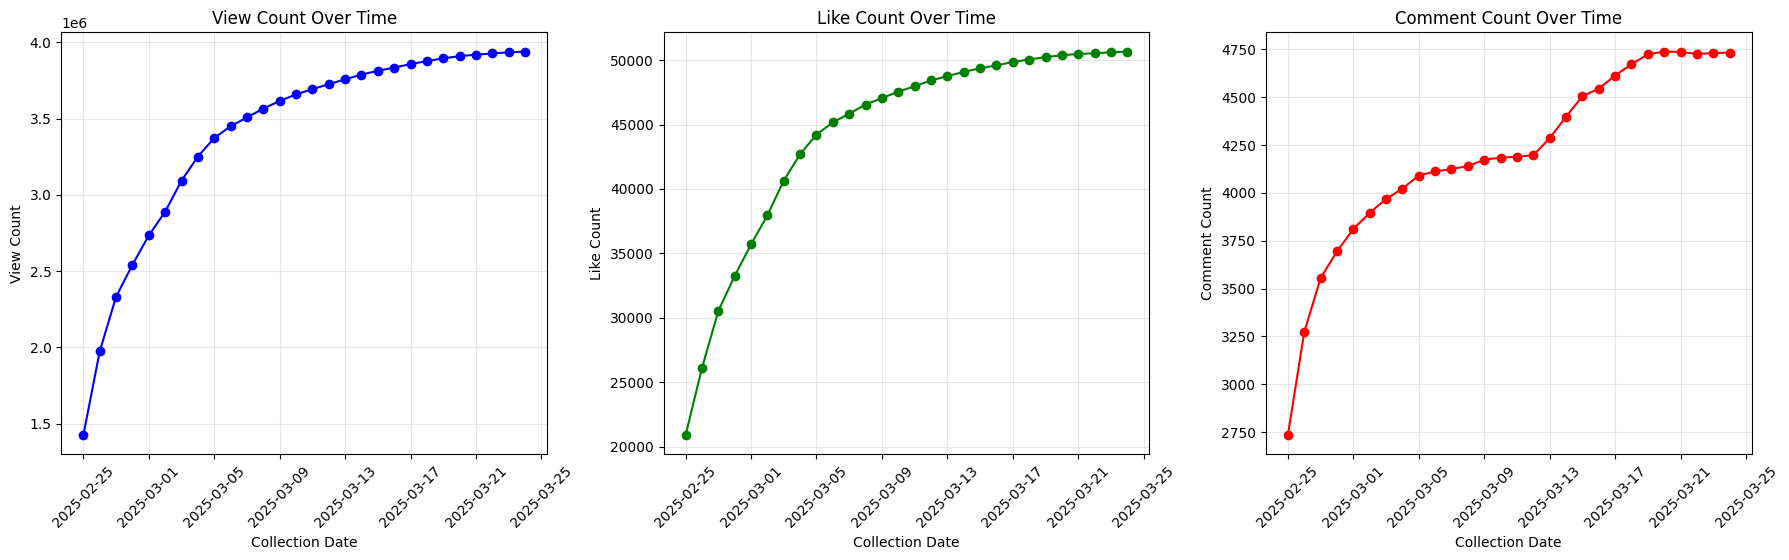

In [25]:
video_stats_visualizer.plot_video_metrics_over_time(video_id).show()

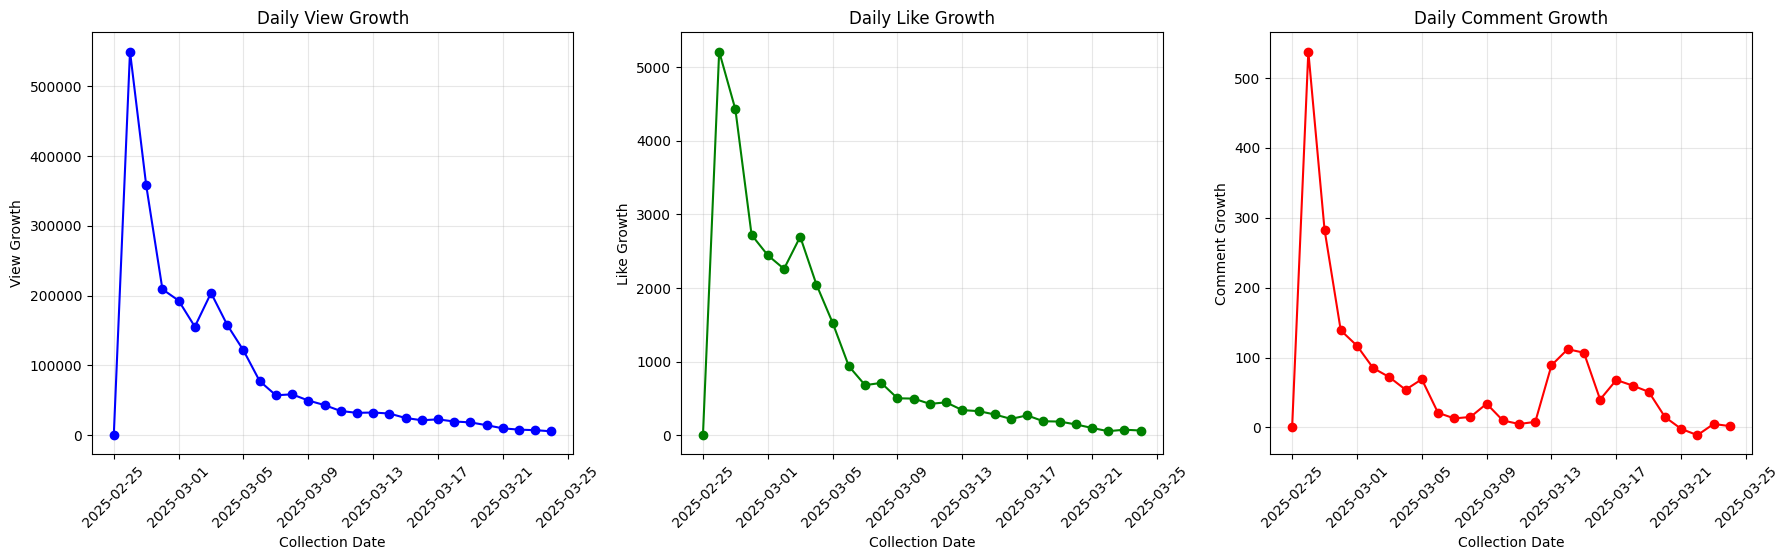

In [26]:
video_stats_visualizer.plot_daily_growth(video_id).show()

In [27]:
video_id = 'dh_LN1Nk5pc'

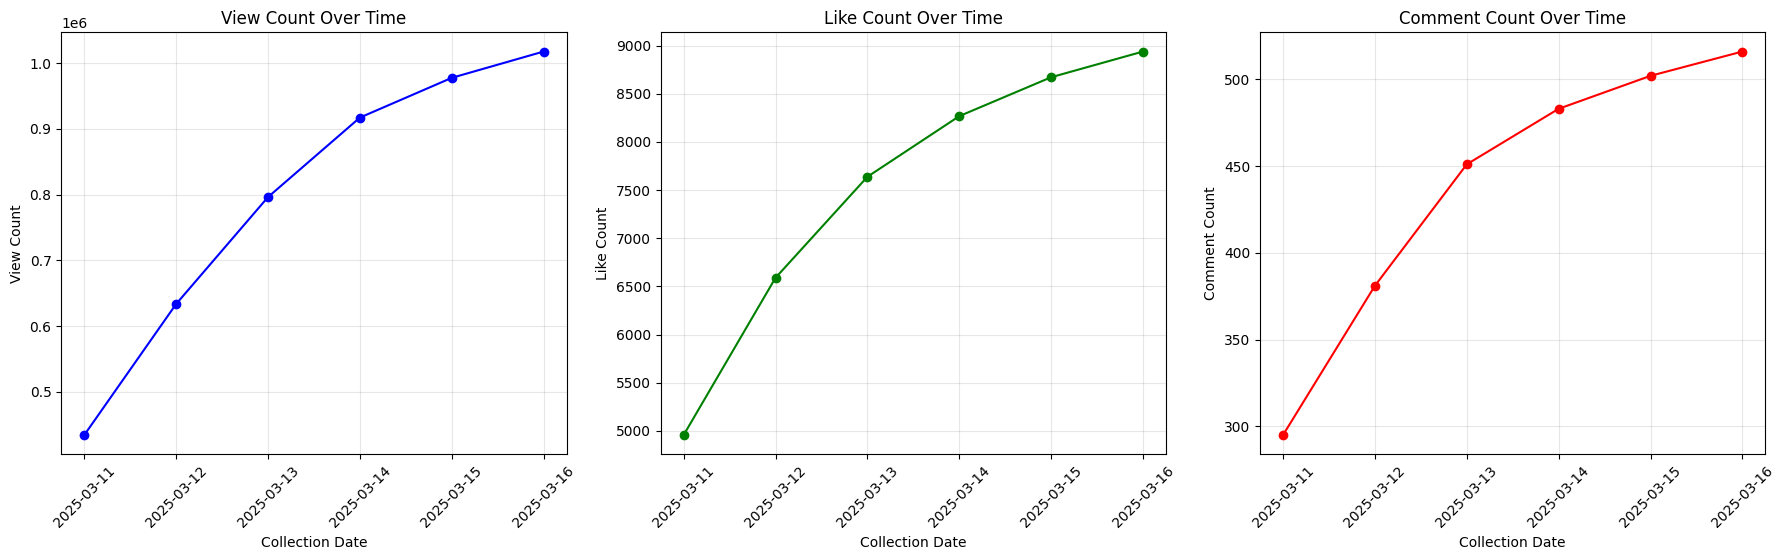

In [28]:
video_stats_visualizer.plot_video_metrics_over_time(video_id).show()

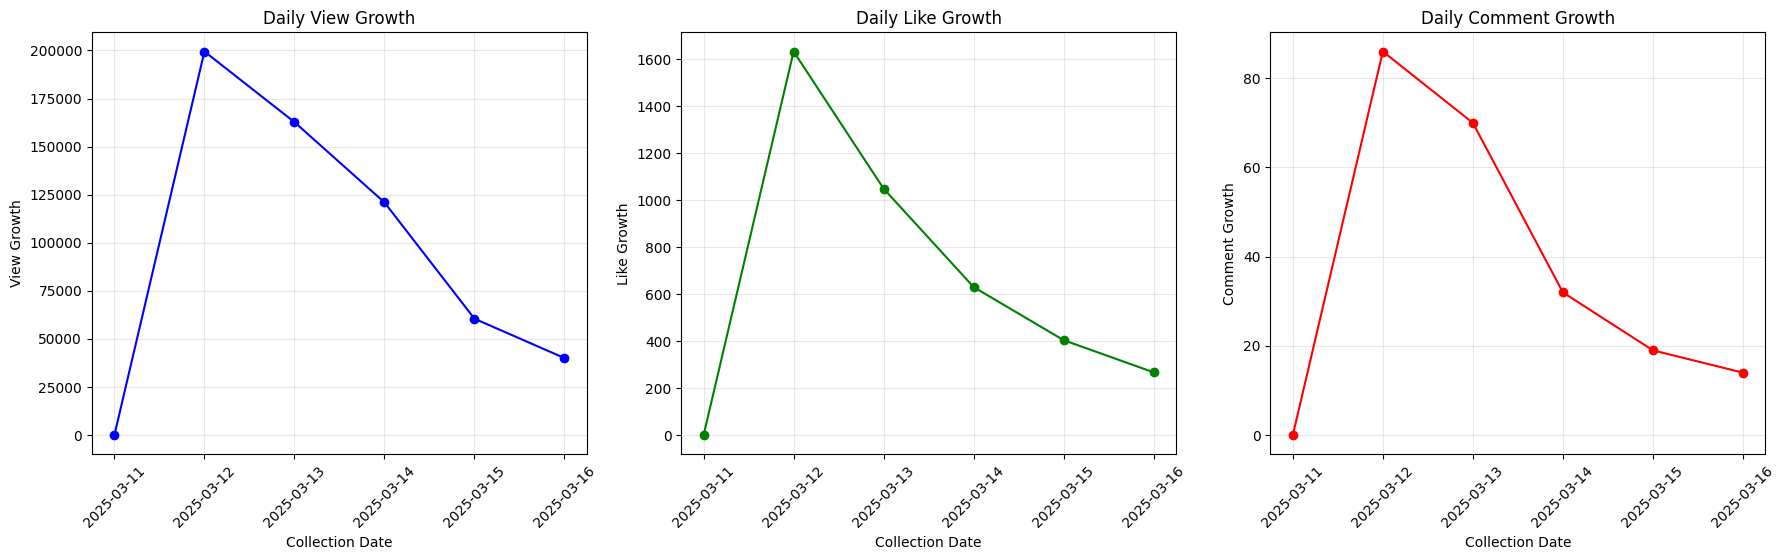

In [29]:
video_stats_visualizer.plot_daily_growth(video_id).show()